-


# Quick reminder of what the model looks like:

It is a heterogenous 2D areal (1-layer) model that is a step up in complexity from our xsec model. Recall it looks like this, as shown in the original Freyberg (1988) paper on the left, and a Groundwater Vistas version on the right (from the file in the GW_Vistas subdirectory).   

<img src="Freyburg1988_fig1.png" style="float: left">

<img src="Freyberg_k_plot_GW_Vistas.png" style="float: right">

### Standard two code blocks to set the notebook up

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_KR
working_dir = fs.WORKING_DIR_KR
fs.setup_pest_kr()
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 0
pst.write(os.path.join(working_dir,pst_name))

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_k_and_r/freyberg_kr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOG

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
run():./pestchek freyberg_kr.pst
run():./pestpp freyberg_kr.init.pst


### Let's run PESTCHEK and see what it says about our freyberg.pst file

In [3]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


#### Curious, in the PESTCHEK warning section it says "All parameters belonging to the parameter group "rch" are either fixed or tied". That is flagged as a warning because PESTCHEK is wondering why would it not be adjustable after you went to all the trouble to define it as a parameter.  But, there  are times you may want to do this, so it is classified as a warning and isn't going to stop you.

### But that is not what we want, we want to make recharge a parameter in this activity.

### Open the PEST control file freyberg.pst in your text editor.  

1) Look in the parameter data section

2) Find the parameter __rch_0__ (the recharge for the calibration period) and make it adjustable (hint:  look at the other parameters) 

3) Save the file

4) Run PESTCHEK on the PEST control file in a seperate terminal window or by executing the next code block and looking at the terminal window where you launched this notebook

In [23]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


Did that parameter group "rch" warning go away?


4) When no errors, run PEST++ by executing the next block (look in your terminal window to see the run progress and wait for the 0 to show up below the code block before continuing).


In [24]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_kr.pst


### ``PEST++`` only ran the model one time - why?

#### This was of course in the warnings when we ran PESTCHEK. Let's do that again in the next block and pay attention to that part of the warnings section (look at the terminal window where you launched this notebook to see the PESTCHEK output). 

In [6]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


In [7]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 20
pst.write(os.path.join(working_dir,pst_name))

#### Let's run PESTCHEK again to make sure

In [8]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_kr.pst


### Now that we've changed NOPTMAX, let's run a PEST++ again.  We set NOPTMAX to 20 so the run is longer - watch your terminal window for progress.  Again, don't advance until you see a 0 returned below the code block.


#### As you watch your terminal window scroll by, look at the right edge where it reports the counter of the runs needed for each PEST++ iteration.  Why does it change?

In [9]:
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp freyberg_kr.pst


### Let's see how we did for our fit:

In [25]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,vol_wells,flx_constan,calhead,flx_total,calflux,vol_in-out,...,vol_recharg,vol_percent,flx_in-out,vol_river_l,head,vol_storage,flx_river_l,vol_constan,foreflux,vol_total
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1207.910,1207.910,0,0,0,1207.910,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,1030.740,1030.740,0,0,0,1030.740,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,702.467,702.467,0,0,0,702.467,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25,700.137,700.137,0,0,0,700.137,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35,700.137,700.137,0,0,0,700.137,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(you can see this information unformatted by opening the .iobj file, which is a comma delimited ASCII PEST++ output file)



### Additional knobs given to PEST gives it more flexibility for fitting the observed data - is the final Phi lower than the last activity?


### You can see individual residuals (and the weights you specified) in the freyberg.rei file.  Here's we'll use Python to calculate the summary statistics for this new run:

In [26]:
pst.phi

738.8823646723391

In [27]:
pst.phi_components

{'calflux': 0.0,
 'calhead': 738.8823646723391,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 0.0,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'foreflux': 0.0,
 'forehead': 0.0,
 'foretrav': 0.0,
 'head': 0.0,
 'pothead': 0.0,
 'vol_constan': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

In [28]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
cr03c16_19700102,cr03c16_19700102,calhead,18.864677,19.827669,-0.962992,5.0
cr03c10_19700102,cr03c10_19700102,calhead,20.920237,22.514858,-1.594621,5.0
cr04c9_19700102,cr04c9_19700102,calhead,23.287189,23.052885,0.234304,5.0
cr10c2_19700102,cr10c2_19700102,calhead,28.141190,29.502222,-1.361032,5.0
cr14c11_19700102,cr14c11_19700102,calhead,20.524639,18.198273,2.326366,5.0
cr16c17_19700102,cr16c17_19700102,calhead,15.522017,17.452532,-1.930515,5.0
cr22c11_19700102,cr22c11_19700102,calhead,19.704904,17.142292,2.562612,5.0
cr23c16_19700102,cr23c16_19700102,calhead,15.644862,15.725641,-0.080779,5.0
cr25c5_19700102,cr25c5_19700102,calhead,21.413268,21.405073,0.008194,5.0


(11.957479976379247, 30.271214640912181)

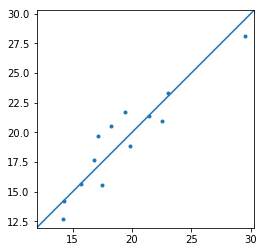

In [29]:
ax = plt.subplot(111,aspect="equal")                                               
ax.scatter(pst.res.loc[pst.nnz_obs_names,"modelled"],pst.res.loc[pst.nnz_obs_names,"measured"],marker='.')
ylim,xlim = ax.get_ylim(),ax.get_xlim()
mn = min(ylim[0],xlim[0])
mx = max(ylim[1],xlim[1])
ax.plot([mn,mx],[mn,mx])
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)

### Hmm, looks familiar.....let's look at the parameter uncertainties:

In [30]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
RCH_0,0.00000,0.055462,-0.110924,0.110924,0.096910,0.054833,-0.012756,0.206576
HK,0.69897,0.500000,-0.301030,1.698970,0.945936,0.079397,0.787141,1.104730


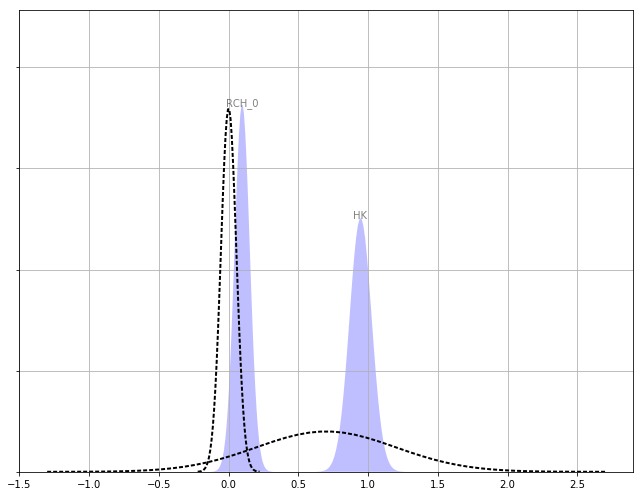

In [39]:
pyemu.helpers.plot_summary_distributions(df_paru,label_post=True)

### Well at least that table is different.  Now let's look at the parameter uncertainties:

#### Here's the K only case from the last activity:

In [31]:
df_paru_single = pd.read_csv(os.path.join("..","freyberg_k","freyberg_un","freyberg_un.par.usum.csv"),index_col=0)
df_paru_single

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.5,-0.30103,1.69897,0.840943,0.054463,0.732017,0.949868


#### Here's the new K+R (left) next the to K only results (right)

In [32]:
df_paru_concat = pd.concat([df_paru,df_paru_single],join="outer",axis=1,keys=["k+r","k_only"])
df_paru_concat

k+r                                                            \
      prior_mean prior_stdev prior_lower_bound prior_upper_bound post_mean   
HK       0.69897    0.500000         -0.301030          1.698970  0.945936   
RCH_0    0.00000    0.055462         -0.110924          0.110924  0.096910   

                                                       k_only              \
      post_stdev post_lower_bound post_upper_bound prior_mean prior_stdev   
HK      0.079397         0.787141         1.104730    0.69897         0.5   
RCH_0   0.054833        -0.012756         0.206576        NaN         NaN   

                                                                \
      prior_lower_bound prior_upper_bound post_mean post_stdev   
HK             -0.30103           1.69897  0.840943   0.054463   
RCH_0               NaN               NaN       NaN        NaN   

                                         
      post_lower_bound post_upper_bound  
HK            0.732017         0.949868  
RCH_0              NaN              NaN

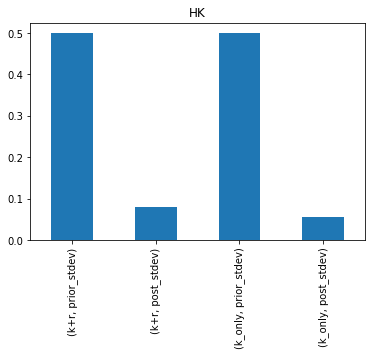

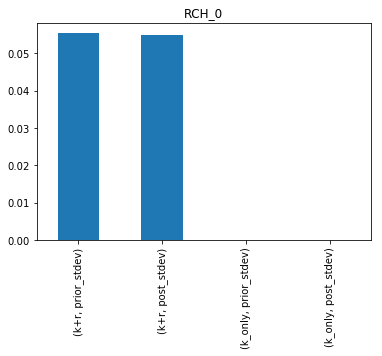

In [33]:
for pname in df_paru_concat.index:
    ax = df_paru_concat.loc[pname,(slice(None),("prior_stdev","post_stdev"))].plot(kind="bar")
    ax.set_title(pname)
    plt.show()

### How does the uncertainty reduction for ``hk`` change when ``rch_0`` is included?

## Now let's look at the forecasts:

#### First, here's our previous results for the K only case:

In [34]:
df_foreu_single = pd.read_csv(os.path.join("..","freyberg_k","freyberg_un","freyberg_un.pred.usum.csv"),index_col=0)
df_foreu_single.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu_single.post_stdev / df_foreu_single.prior_stdev))
df_foreu_single

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound,reduction
name,,,,,,,,,
FLX_RIVER_L_19750102,-1436.1400,212.304000,-1860.7500,-1011.5400,-1487.5700,23.125300,-1533.8200,-1441.3200,89.107459
FR01C13_19750102,20.5560,0.763994,19.0280,22.0840,20.3039,0.083218,20.1375,20.4704,89.107454
FR02C02_19750102,27.1473,5.813150,15.5210,38.7736,25.3133,0.633201,24.0469,26.5797,89.107437
FR03C10_19750102,22.0427,2.440350,17.1620,26.9234,21.2456,0.265816,20.7140,21.7772,89.107464
FR03C16_19750102,19.6050,0.310456,18.9841,20.2259,19.5016,0.033817,19.4340,19.5692,89.107442
FR04C9_19750102,22.4907,2.894170,16.7024,28.2791,21.5493,0.315249,20.9188,22.1798,89.107447
FR09C15_19750102,17.0955,1.042820,15.0099,19.1812,17.4461,0.113589,17.2189,17.6733,89.107516
FR10C2_19750102,28.4562,7.083020,14.2902,42.6223,26.2424,0.771522,24.6994,27.7854,89.107443
FR14C11_19750102,17.7482,0.656200,16.4358,19.0606,17.5293,0.071477,17.3863,17.6723,89.107452


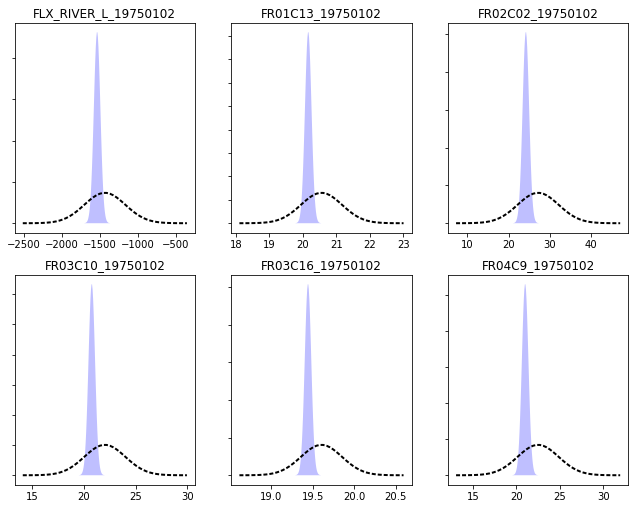

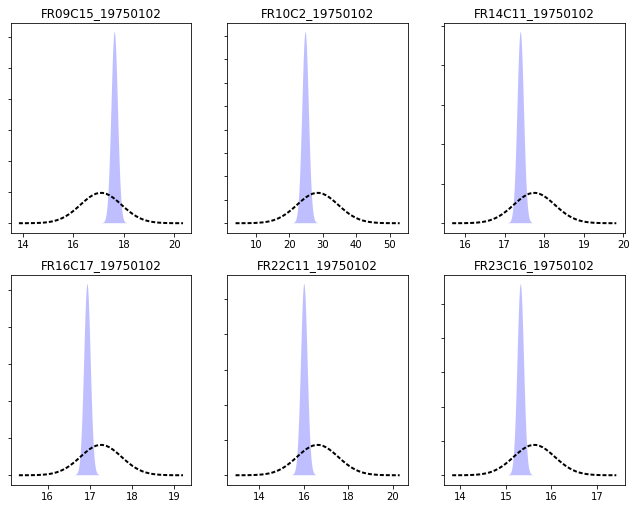

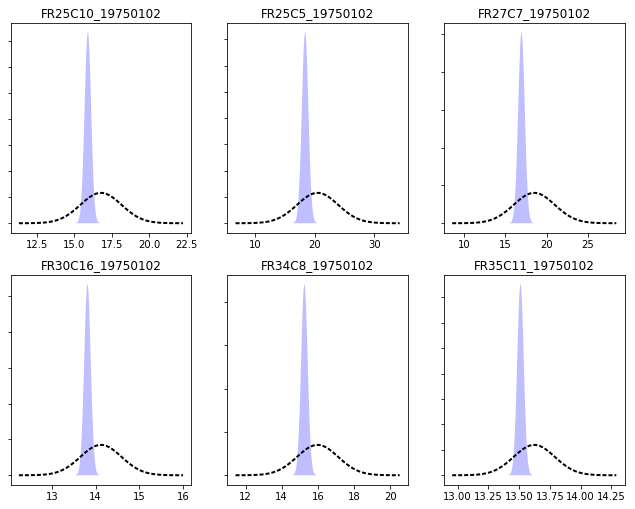

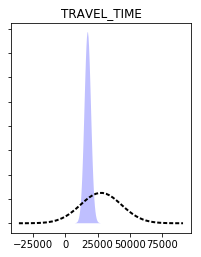

In [41]:
axes = pyemu.helpers.plot_summary_distributions(df_foreu,subplots=True)

#### Here's our new run where K and R are parameters:

In [35]:
df_foreu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_foreu.loc[:,"reduction"] = 100.0 *  (1.0 - (df_foreu.post_stdev / df_foreu.prior_stdev))
df_foreu_concat = pd.concat([df_foreu,df_foreu_single],join="outer",axis=1,keys=["k+r","k_only"])
df_foreu_concat

k+r                                  \
                      prior_mean   prior_stdev prior_lower_bound   
name                                                               
FLX_RIVER_L_19750102  -1436.1400    270.420000        -1976.9800   
FR01C13_19750102         20.5560      0.613784           19.3284   
FR02C02_19750102         27.1473      4.961890           17.2235   
FR03C10_19750102         22.0427      1.978620           18.0854   
FR03C16_19750102         19.6050      0.246907           19.1112   
FR04C9_19750102          22.4907      2.358900           17.7729   
FR09C15_19750102         17.0955      0.812541           15.4704   
FR10C2_19750102          28.4562      6.143120           16.1700   
FR14C11_19750102         17.7482      0.518120           16.7120   
FR16C17_19750102         17.2635      0.485907           16.2917   
FR22C11_19750102         16.6192      0.924128           14.7709   
FR23C16_19750102         15.6226      0.450015           14.7226   
FR25C10_19750102         16.7860      1.368120           14.0498   
FR25C5_19750102          20.4690      3.442550           13.5839   
FR27C7_19750102          18.5070      2.478560           13.5499   
FR30C16_19750102         14.1212      0.470100           13.1810   
FR34C8_19750102          15.9855      1.135420           13.7146   
FR35C11_19750102         13.6223      0.166822           13.2887   
TRAVEL_TIME           27691.0000  15938.400000        -4185.8400   

                                                                 \
                     prior_upper_bound   post_mean   post_stdev   
name                                                              
FLX_RIVER_L_19750102         -895.3030  -1538.0200    42.942600   
FR01C13_19750102               21.7836     20.1599     0.097465   
FR02C02_19750102               37.0711     24.1842     0.787943   
FR03C10_19750102               25.9999     20.7833     0.314208   
FR03C16_19750102               20.0988     19.4429     0.039207   
FR04C9_19750102                27.2085     20.9996     0.374594   
FR09C15_19750102               18.7206     17.6399     0.129027   
FR10C2_19750102                40.7425     24.8562     0.975546   
FR14C11_19750102               18.7845     17.4067     0.082275   
FR16C17_19750102               18.2353     16.9435     0.077159   
FR22C11_19750102               18.4675     16.0200     0.146746   
FR23C16_19750102               16.5226     15.3272     0.071460   
FR25C10_19750102               19.5223     15.9136     0.217241   
FR25C5_19750102                27.3541     18.3762     0.546659   
FR27C7_19750102                23.4641     16.9680     0.393568   
FR30C16_19750102               15.0614     13.8119     0.074649   
FR34C8_19750102                18.2563     15.2551     0.180292   
FR35C11_19750102               13.9560     13.5106     0.026484   
TRAVEL_TIME                 59567.8000  17428.5000  2530.790000   

                                                                       k_only  \
                     post_lower_bound post_upper_bound  reduction  prior_mean   
name                                                                            
FLX_RIVER_L_19750102       -1623.9100       -1452.1400  84.120036  -1436.1400   
FR01C13_19750102              19.9650          20.3548  84.120554     20.5560   
FR02C02_19750102              22.6083          25.7601  84.120103     27.1473   
FR03C10_19750102              20.1548          21.4117  84.119841     22.0427   
FR03C16_19750102              19.3644          19.5213  84.120580     19.6050   
FR04C9_19750102               20.2504          21.7488  84.119971     22.4907   
FR09C15_19750102              17.3819          17.8980  84.120555     17.0955   
FR10C2_19750102               22.9051          26.8073  84.119698     28.4562   
FR14C11_19750102              17.2422          17.5713  84.120551     17.7482   
FR16C17_19750102              16.7892          17.0978  84.120542     17.2635   
FR22

## Better to plot them:

### (blue is k and r, green is k only)

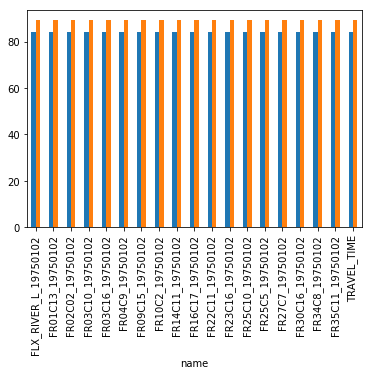

In [36]:
df_foreu_concat.loc[:,(slice(None),"reduction")].plot(kind="bar", legend=False)

### Which forecasts are influenced by the ``rch_0`` parameter?  

### Which forecasts were more or less unchanged - why?

### Which case (``K`` or ``K+R``) provides the more robust uncertainty estimate?

# Wait, something is amiss.  

### Look at this slightly modified version of the groundwater governing equation from Anderson et al. (2015) below.  Is this problem well posed? That is, if recharge increased (represented by an increase in $W^*$) *and* at the same time K increased (represented by an increase in q) could they offset each other so that the righthand side stays the same? What is this called?

 
  <img src="GW_GE2.jpg" style="float: center">
 
 
 ### Recall the Bravo et al. (2002) trough when calibrating K and R with only heads:
 
  <img src="Fig9.11a_bravo_trough.jpeg" style="float: center">
  
  ****************
 

###  Even though estimating both R and K using only head observations is not possible, PEST++ gave you an answer.  How? (Hint:  look in the .rec file and see what happens to the parameters over the course of the run)


## Let's dig into the PEST result a bit more...

1) Compare the optimal rch1 parameter value in the __freyberg.rec__ file (search for "Optimal parameter values" without the quotation marks) to the rch1 parameter data the instructors supplied in the PEST control file.  

2) Where does the optimal parameter lie with respect to the bounds that were given for the parameter? 

3) Open the __freyberg.ipar__ file in a text editor.  What was the iteration history of rch1?

# Let's look at the correlation

In [37]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
cov = pyemu.Cov(sc.xtqx.x, names=sc.pst.adj_par_names)
R = cov.to_pearson()
R.df()

,rch_0,hk
rch_0,1.000000,-0.996731
hk,-0.996731,1.000000


# Let's test how "optimal" these parameters are. 

1) Open freyberg_kr\freyberg_kr.pst in a text editor, 

2) change the upper bound of the rch_0 parameter from 1.5500000000E-04 to 2.5500000000E-04

3) re-run pestpp

4) open the __freyberg_kr.ipar__ file in a text editor.  

# Last points:

## Do you believe that value is optimal, or even defensible?  Should we believe the forecast uncertainty either?